<a href="https://colab.research.google.com/github/samia-boubaya/project-01-escape-room-game/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **PROJECT 01: ESCAPE ROOM GAME**
### IRONHACK DATA BOOTCAMP

Welcome to escape room quest

You wake up in a couch in a misteryous house with locked doors.
Your mission: Find the keys, unlock each room, and escape to freedom!

In this notebook we start by building the data structures that define the game world, which are: rooms, objects, keys and doors.

**Definition of an escape room:**

The briefing room of an escape room in Tampere, Finland
Escape rooms are inspired by escape room video games, live-action role-playing, point-and-click adventure games, puzzle hunts, interactive theater, and haunted houses. They are also referred to as "room escapes", "escape games", "exit games", or "live escapes".


---

## TEAM NOTES ⭐
### TO ADD:
*   Quiz the player when door is unlocked (comes after the unlock_door function)
*   Tell the player how much time he has left to escape and win this game (print and library of time)
*   Add how much it took the player to finish the game (important in the game_state)
*   Add Live timer and show player their countdown timer (extra)

*   Add list of game_doors to compare with current_space doors to show availabe doors for the player to after that choose which door to try unlock the door using keys from inventory.
*   horror sounds to every room, and KA-CHING for unlocking door, and different winning sound when outside

---

### ERROR HANDLING:
*   Capital letters input error when comparing with our data 
*   Capitalize first letter when printing using .title()
*   No input and enter error






---
## GAME DATA (DICT & LIST)

### DICT : GAME AREAS

In [ ]:
# Each key in this dictionary represents a room; each value is a list of objects, doors and keys

# Dictionary : GAME AREAS
game_areas = {
    "game room" : ['couch', 'piano', 'door A', 'key door A'],
    "bedroom 1": ['queen bed', 'door A', 'door B', 'door C', 'key door B'],
    "bedroom 2": ['double bed', 'door B', 'dresser', 'key door D', 'key door C'],
    "living room": ["dining table", 'door C', 'door D'],
    "outside": ["freedom"]
}

# List : dictionary Keys
spaces = game_areas.keys()
print("GAME AREAS Dictionary:")
print("Dictionary Keys:\n",spaces,"\n")

# Print dictionary organised
print("Dictionary:\n{   key   :   value     }")
for i in spaces:
  print(i,":",game_areas[i])

### DICT : GAME STATE

In [ ]:
# Keep track of the player : current space; current item to examine; and inventory of keys
# Dict : GAME STATE
game_state = {
    'space_path' : [], # player current space to navigate and make a space path
    'item_path' : [], # to select an item to examine for key; and make an item path
    'inventory': [], # to store found keys
    'time': ["display_clock_countdown"] , #library time for live timer and countdown
}

# List : dictionary Keys
states = game_state.keys()
print("GAME STATE Dictionary:")
print("Dictionary Keys:\n",states,"\n")

# Print dictionary organised
print("Dictionary:\n{   key   :   value     }")
for i in states:
  print(i,":",game_state[i])

---
### DICT : SOUNDS (EXTRA FEATURE)

In [ ]:

# Use dict to create sounds in game
# Dict : sounds
game_sounds = {
    'space sound': "WOOD CRACKING LINK", # space sound for every space 'wind'
    'key found sound': "HURRAY  LINK", # key found sound for finding key like 'hurray'
    'unlock door sound' : "CLICK DOWNLOADABLE LINK", # unlock door sound for unlocking door after solving quiz like 'click'
          }

print("GAME SOUNDS Dictionary:")
# List : dictionary Keys
sounds = game_sounds.keys()
print("Dictionary Keys:\n", sounds, "\n")

# print dict : sounds
# Print dictionary organised
print("Dictionary:\n{   key   :   value     }")
for i in sounds:
  print(i,":",game_sounds[i])

--------

# GAME TRIGGERS (EXTRA FEATURE): 

## PLAY IN BACKGROUND FOR 5 MINUTES

In [ ]:
import requests
from playsound import playsound
import threading
import time

# 🎵 Game sound triggers
game_triggers = {
    'space': "https://drive.google.com/uc?export=download&id=1jhDDigPt00xLUvex7Z9O5r1xmOzsYxkB",
    'door locked': "https://drive.google.com/uc?export=download&id=1kKXJ3bYl5F2vQX1Z3Yz5G7H8J9L0M2N3",
    'door unlocked': "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
    'footstep': "https://drive.google.com/uc?export=download&id=1aB2cD3eF4gH5iJ6kL7mN8oP9qR0sT1U",
    'action': "https://drive.google.com/uc?export=download&id=1V2wX3yZ4aB5cD6eF7gH8iJ9kL0mN1O2P"
}

# 🔊 Function to play a sound in a loop for 5 minutes in the background
def play_background_sound(trigger):
    url = game_triggers[trigger]
    # download the audio file
    r = requests.get(url, allow_redirects=True)
    with open('bg_sound.mp3', 'wb') as f:
        f.write(r.content)

    # function to loop the sound
    def loop_sound():
        start = time.time()
        while time.time() - start < 300:  # 300 seconds = 5 minutes
            playsound('bg_sound.mp3', block=True)

    # start background thread so it doesn’t block the game
    threading.Thread(target=loop_sound, daemon=True).start()

# 🎮 Main trigger function
def play_sound(trigger):
    trigger = trigger.lower().strip()
    if trigger == 'space':
        print("Exploring... space background music playing 🔎")
        play_background_sound(trigger)
    elif trigger == 'door locked':
        print("Unlocking... door locked sound playing 🔒")  # only when quiz correct answer
        play_background_sound(trigger)
    elif trigger == 'door unlocked':
        print("Unlocking... door unlocked sound playing 🔓")  # only when quiz correct answer
        play_background_sound(trigger)
    elif trigger == 'footstep':
        print("Navigating... footstep sound playing 👣")
        play_background_sound(trigger)
    elif trigger == 'examine item':
        print("Examining... item sound playing 🕵️‍♀️")
        play_background_sound(trigger)
    else:
        print("No sound defined for this trigger.")
    # play the sound in background for 5 minutes
    

# --- Example usage ---
play_sound('door unlocked')



## DISPLAY IMAGE in a terminal like window

We need to display in a terminal like window :

Choose your action from this list

input 
output

### CHECK URL DOWNLOADABLE

In [ ]:
# check url if they are downloadable
import requests

urls = [
    "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
    "https://drive.google.com/uc?export=download&id=1_NsFQxkNlO9O11OaqhK6QxY1NhhxbI-o",
    "https://drive.google.com/uc?export=download&id=1-BwRmk_3U6TRESsPja5s26ECB8GYcqOU",
    "https://drive.google.com/uc?export=download&id=1drL22OHO91OgjpT942g2nrmgRZcr0gYa",
    "https://drive.google.com/uc?export=download&id=1mlkfF9RW6uhKMeBqixYZlo5w-dVJ_1Uo",
    "https://drive.google.com/uc?export=download&id=16snfruJnkMN8fkxL_fxDzwCaNhNdRroN",
]

for url in urls:
    try:
        r = requests.get(url, stream=True, timeout=10)
        print(f"{url} → {r.status_code} ({r.headers.get('Content-Type')})")
    except Exception as e:
        print(f"{url} → Error: {e}")


### INSTALL

In [ ]:
!pip install pillow
!pip install playsound==1.2.2
!pip install pyobjc

### IMPORT & DICT

In [ ]:
import os
import threading
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
import requests
from playsound import playsound

# --- Optional alternative audio player for reliability ---
try:
    from playsound import playsound
except ImportError:
    raise ImportError("Install with: pip install playsound==1.2.2")



# 🎵 GAME SOUND & IMAGE TRIGGERS
game_triggers = {
    'door unlocked': {
        'sound': "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        'image': "https://drive.google.com/uc?export=download&id=1_NsFQxkNlO9O11OaqhK6QxY1NhhxbI-o",
    },
    'door locked': {
        'sound': "https://drive.google.com/uc?export=download&id=1-BwRmk_3U6TRESsPja5s26ECB8GYcqOU",
        'image': "https://drive.google.com/uc?export=download&id=1drL22OHO91OgjpT942g2nrmgRZcr0gYa",
    },
    'footstep': {
        'sound': "https://drive.google.com/uc?export=download&id=1mlkfF9RW6uhKMeBqixYZlo5w-dVJ_1Uo",
        'image': "https://drive.google.com/uc?export=download&id=16snfruJnkMN8fkxL_fxDzwCaNhNdRroN",
    },
}

### TEST WITH PICTURE VIEWER

In [ ]:
import os
import threading
import platform
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
import requests

# --- Optional alternative audio player for reliability ---
try:
    from playsound import playsound
except ImportError:
    raise ImportError("Install with: pip install playsound==1.2.2")

# 🎵 GAME SOUND & IMAGE TRIGGERS
game_triggers = {
    'door unlocked': {
        'sound': "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        'image': "https://drive.google.com/uc?export=download&id=1_NsFQxkNlO9O11OaqhK6QxY1NhhxbI-o",
    },
    'door locked': {
        'sound': "https://drive.google.com/uc?export=download&id=1-BwRmk_3U6TRESsPja5s26ECB8GYcqOU",
        'image': "https://drive.google.com/uc?export=download&id=1drL22OHO91OgjpT942g2nrmgRZcr0gYa",
    },
    'footstep': {
        'sound': "https://drive.google.com/uc?export=download&id=1mlkfF9RW6uhKMeBqixYZlo5w-dVJ_1Uo",
        'image': "https://drive.google.com/uc?export=download&id=16snfruJnkMN8fkxL_fxDzwCaNhNdRroN",
    },
}


# 🧠 UTILITY: Download & cache file
def download_file(url, filename):
    if not os.path.exists(filename):
        print(f"⬇️ Downloading {filename}...")
        r = requests.get(url, allow_redirects=True)
        with open(filename, 'wb') as f:
            f.write(r.content)
    return filename


# 🔊 SOUND PLAYER (cross-platform)
def play_sound_from_url(url, trigger_name):
    local_file = f"{trigger_name.replace(' ', '_')}.mp3"
    download_file(url, local_file)

    def play():
        try:
            # macOS sometimes fails with playsound; fallback to afplay
            if platform.system() == "Darwin":
                os.system(f"afplay '{local_file}' &")
            else:
                playsound(local_file, block=False)
        except Exception as e:
            print(f"⚠️ Sound error: {e}")

    threading.Thread(target=play, daemon=True).start()


# 🖼️ IMAGE DISPLAY (must run in main thread)
def show_image(url, duration=4000, title="Game Event", trigger_name="default"):
    local_img = f"{trigger_name.replace(' ', '_')}.gif"
    download_file(url, local_img)

    win = tk.Toplevel()
    win.title(title)
    win.configure(bg="black")

    try:
        img = Image.open(local_img)
        tk_img = ImageTk.PhotoImage(img)
        label = tk.Label(win, image=tk_img, bg="black")
        label.image = tk_img  # keep reference!
        label.pack()
    except Exception as e:
        print(f"Image error: {e}")

    # Auto-close popup after `duration` milliseconds
    win.after(duration, win.destroy)


# 🎮 MAIN TRIGGER FUNCTION
def play_trigger(trigger):
    trigger = trigger.lower().strip()
    if trigger not in game_triggers:
        print("Unknown trigger:", trigger)
        return

    data = game_triggers[trigger]
    sound_url = data.get('sound')
    image_url = data.get('image')

    print(f"Trigger: {trigger.capitalize()}")

    if sound_url:
        play_sound_from_url(sound_url, trigger)

    if image_url:
        root.after(0, lambda: show_image(image_url, title=trigger.capitalize(), trigger_name=trigger))



# 🚀 MAIN LOOP
if __name__ == "__main__":
    root = tk.Tk()
    root.withdraw()  # Hide main window

    # 🔹 TEST EVENTS
    trigger = 'door unlocked'
    play_trigger(trigger)


    root.mainloop()  # Call only once at the end

----
## IMAGE + SOUND USING IMAGE VIEWER AND IMAGE FRAME

In [ ]:
import os
import threading
import platform
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
import requests

try:
    from playsound import playsound
except ImportError:
    raise ImportError("Please install playsound with: pip install playsound==1.2.2")

# =============================================
# ⚙️ CONFIGURATION
# =============================================

TRIGGERS = {
    "door unlocked": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": "https://drive.google.com/uc?export=download&id=1_NsFQxkNlO9O11OaqhK6QxY1NhhxbI-o",
    },
    "door locked": {
        "sound": "https://drive.google.com/uc?export=download&id=1-BwRmk_3U6TRESsPja5s26ECB8GYcqOU",
        "image": "https://drive.google.com/uc?export=download&id=1drL22OHO91OgjpT942g2nrmgRZcr0gYa",
    },
    "footstep": {
        "sound": "https://drive.google.com/uc?export=download&id=1mlkfF9RW6uhKMeBqixYZlo5w-dVJ_1Uo",
        "image": "https://drive.google.com/uc?export=download&id=16snfruJnkMN8fkxL_fxDzwCaNhNdRroN",
    },
}

CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# =============================================
# 🧠 UTILITIES
# =============================================

def download_file(url: str, name: str) -> str | None:
    """Download a file if not cached, return local path."""
    local_path = os.path.join(CACHE_DIR, name)
    if os.path.exists(local_path):
        return local_path

    print(f"⬇️ Downloading {name}...")
    try:
        response = requests.get(url, allow_redirects=True, timeout=15)
        response.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(response.content)
        return local_path
    except Exception as e:
        print(f"⚠️ Download error for {url}: {e}")
        return None

# =============================================
# 🔊 SOUND PLAYER
# =============================================

def play_sound(url: str, trigger_name: str):
    """Play sound asynchronously."""
    local_file = download_file(url, f"{trigger_name}.mp3")
    if not local_file:
        return

    def _play():
        try:
            if platform.system() == "Darwin":
                os.system(f"afplay '{local_file}' &")
            elif platform.system() == "Linux":
                os.system(f"mpg123 '{local_file}' >/dev/null 2>&1 &")
            else:
                playsound(local_file, block=False)
        except Exception as e:
            print(f"⚠️ Sound error: {e}")

    threading.Thread(target=_play, daemon=True).start()

# =============================================
# 🖼️ GUI CLASS
# =============================================

class GameUI(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("🎮 Game Trigger Visualizer")
        self.configure(bg="#101010")
        self.geometry("600x500")

        # Image display frame only (no text)
        self.image_label = ttk.Label(self)
        self.image_label.pack(expand=True)

    def show_trigger(self, trigger: str):
        """Play sound and show image inline without any text output."""
        trigger = trigger.lower().strip()
        data = TRIGGERS.get(trigger)
        if not data:
            return  # silently ignore unknown triggers

        # Play sound
        if data.get("sound"):
            play_sound(data["sound"], trigger.replace(" ", "_"))

        # Show image inline
        if data.get("image"):
            local_file = download_file(data["image"], f"{trigger}.gif")
            if local_file:
                try:
                    img = Image.open(local_file)
                    img = img.resize((400, 300), Image.Resampling.LANCZOS)
                    tk_img = ImageTk.PhotoImage(img)
                    self.image_label.config(image=tk_img)
                    self.image_label.image = tk_img
                except Exception:
                    pass  # silently ignore image errors

# =============================================
# 🚀 ENTRY POINT
# =============================================

if __name__ == "__main__":
    app = GameUI()

    # Example: directly show a trigger
    trigger = 'door locked'
    app.show_trigger(trigger)

    trigger = 'door unlocked'
    app.show_trigger(trigger)

    app.mainloop()


TESTING TO DISPLAY AND RUN ONE IMAGE AND SOUND AT A TIME

In [ ]:
# =============================================
# 🚀 ENTRY POINT
# =============================================

if __name__ == "__main__":
    app = GameUI()

    # Example: directly show a trigger
    trigger = 'footstep'
    app.show_trigger(trigger)

    app.mainloop()

## COPY

In [ ]:
import os
import threading
import platform
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
import requests
import time

try:
    from playsound import playsound
except ImportError:
    raise ImportError("Please install playsound with: pip install playsound==1.2.2")

# =============================================
# ⚙️ CONFIGURATION
# =============================================

TRIGGERS = {
    "game room": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": "https://drive.google.com/uc?export=download&id=1_NsFQxkNlO9O11OaqhK6QxY1NhhxbI-o",
    },    
    "bedroom 1": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": "https://drive.google.com/uc?export=download&id=1_NsFQxkNlO9O11OaqhK6QxY1NhhxbI-o",
    },
# add other spaces as well

    "examine": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": "https://drive.google.com/uc?export=download&id=1_NsFQxkNlO9O11OaqhK6QxY1NhhxbI-o",
    },

    "found key": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": "https://drive.google.com/uc?export=download&id=1_NsFQxkNlO9O11OaqhK6QxY1NhhxbI-o",
    },

    "not found key": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": "https://drive.google.com/uc?export=download&id=1_NsFQxkNlO9O11OaqhK6QxY1NhhxbI-o",
    },


    "quiz": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": "https://drive.google.com/uc?export=download&id=1_NsFQxkNlO9O11OaqhK6QxY1NhhxbI-o",
    },

    "door locked": {
        "sound": "https://drive.google.com/uc?export=download&id=1-BwRmk_3U6TRESsPja5s26ECB8GYcqOU",
        "image": "https://drive.google.com/uc?export=download&id=1drL22OHO91OgjpT942g2nrmgRZcr0gYa",
    },

    "door unlocked": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": "https://drive.google.com/uc?export=download&id=1_NsFQxkNlO9O11OaqhK6QxY1NhhxbI-o",
    },

    "footstep": {
        "sound": "https://drive.google.com/uc?export=download&id=1mlkfF9RW6uhKMeBqixYZlo5w-dVJ_1Uo",
        "image": "https://drive.google.com/uc?export=download&id=16snfruJnkMN8fkxL_fxDzwCaNhNdRroN",
    },
}

CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# =============================================
# 🧠 UTILITIES
# =============================================

def download_file(url: str, name: str) -> str | None:
    """Download a file if not cached, return local path."""
    local_path = os.path.join(CACHE_DIR, name)
    if os.path.exists(local_path):
        return local_path

    print(f"⬇️ Downloading {name}...")
    try:
        response = requests.get(url, allow_redirects=True, timeout=15)
        response.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(response.content)
        return local_path
    except Exception as e:
        print(f"Download error for {url}: {e}")
        return None

# =============================================
# 🔊 SOUND PLAYER
# =============================================

def play_sound(url: str, trigger_name: str):
    """Play sound asynchronously."""
    local_file = download_file(url, f"{trigger_name}.mp3")
    if not local_file:
        return

    def _play():
        try:
            if platform.system() == "Darwin":
                os.system(f"afplay '{local_file}' &")
            elif platform.system() == "Linux":
                os.system(f"mpg123 '{local_file}' >/dev/null 2>&1 &")
            else:
                playsound(local_file, block=False)
        except Exception as e:
            print(f"Sound error: {e}")

    threading.Thread(target=_play, daemon=True).start()

# =============================================
# 🖼️ MAIN GAME UI CLASS
# =============================================

class GameUI(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Game Trigger Visualizer")
        self.configure(bg="#101010")
        self.geometry("600x500")

        self.image_label = ttk.Label(self)
        self.image_label.pack(expand=True)

    def show_trigger(self, trigger: str):
        """Play sound and show image inline."""
        trigger = trigger.lower().strip()
        data = TRIGGERS.get(trigger)
        if not data:
            print(f" Unknown trigger: {trigger}")
            return

        # Play sound
        if data.get("sound"):
            play_sound(data["sound"], trigger.replace(" ", "_"))

        # Show image
        if data.get("image"):
            local_file = download_file(data["image"], f"{trigger}.gif")
            if local_file:
                try:
                    img = Image.open(local_file)
                    img = img.resize((400, 300), Image.Resampling.LANCZOS)
                    tk_img = ImageTk.PhotoImage(img)
                    self.image_label.config(image=tk_img)
                    self.image_label.image = tk_img
                except Exception as e:
                    print(f" Image error: {e}")

# =============================================
# 🚀 GLOBAL APP INSTANCE + CALLABLE FUNCTION
# =============================================

# Create the app globally
app = GameUI()

def trigger_event(trigger_name: str):
    """Public function to call triggers from anywhere."""
    if not trigger_name:
        print(" No trigger name provided.")
        return
    app.after(0, lambda: app.show_trigger(trigger_name))

# =============================================
# 🚀 MAIN
# =============================================
if __name__ == "__main__":
    # You can test any trigger freely here:
    def test_triggers():
        # call any trigger manually, one at a time
        time.sleep(1)
        trigger_event("door locked")
        time.sleep(2)
        trigger_event("footstep")
        time.sleep(2)
        trigger_event("door unlocked")
        time.sleep(2)
        trigger_event("quiz")

    # Run test in background (optional)
    threading.Thread(target=test_triggers, daemon=True).start()

    # Start GUI loop
    app.mainloop()


# fix this code so i can use the function trigger_event(trigger:str) to call for the trigger to display sound and image just like it does above but
# i want to also not force me into a sequence of triggers i wanna be able to call just one trigger with this function depends on the value of trigger

In [ ]:
import os
import threading
import platform
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
import requests
import time
import hashlib

try:
    from playsound import playsound
except ImportError:
    raise ImportError("Please install playsound with: pip install playsound==1.2.2")

# =============================================
# ⚙️ CONFIGURATION
# =============================================

TRIGGERS = {
    "game room": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": None,
    },    
    "bedroom 1": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": None,
    },
    "examine": {
        "sound": "https://drive.google.com/uc?export=download&id=1_FbFeK51rtIMWg9yQovpurNGHHWukYoD",
        "image": "https://drive.google.com/uc?export=download&id=1igPXeO1Ro-UUL1tMQsMAQqOZE1kPundT",
    },
    "found key": {
        "sound": "https://drive.google.com/uc?export=download&id=1MhGR7E9YXp7LrzKaSMlCGd211I18P6Iy",
        "image": "https://drive.google.com/uc?export=download&id=1hcyiCkmmchsGZ2ERsx8PMdEN3kh--tO5",
    },
    "not found key": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": "https://drive.google.com/uc?export=download&id=1_NsFQxkNlO9O11OaqhK6QxY1NhhxbI-o",
    },
    "quiz": {
        "sound": "https://drive.google.com/uc?export=download&id=1wbj__J8nYqmeOh1gCmZVaWWqMbF4MNyp",
        "image": None,
    },
    "door locked": {
        "sound": "https://drive.google.com/uc?export=download&id=1-BwRmk_3U6TRESsPja5s26ECB8GYcqOU",
        "image": "https://drive.google.com/uc?export=download&id=1drL22OHO91OgjpT942g2nrmgRZcr0gYa",
    },
    "door unlocked": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": "https://drive.google.com/uc?export=download&id=1TXSjKZXC_K0c4gXrQlTY20u_X2aEVQ1_",
    },
    "footstep": {
        "sound": "https://drive.google.com/uc?export=download&id=1mlkfF9RW6uhKMeBqixYZlo5w-dVJ_1Uo",
        "image": "https://drive.google.com/uc?export=download&id=16snfruJnkMN8fkxL_fxDzwCaNhNdRroN",
    },
}

CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# =============================================
# 🧠 UTILITIES
# =============================================

def download_file(url: str, name: str) -> str | None:
    """Download a file if not cached, return local path."""
    # Use a unique hash of the URL to avoid name collisions
    url_hash = hashlib.md5(url.encode()).hexdigest()[:8]
    base, ext = os.path.splitext(name)
    unique_name = f"{base}_{url_hash}{ext}"

    local_path = os.path.join(CACHE_DIR, unique_name)
    if os.path.exists(local_path):
        return local_path

    print(f"⬇️ Downloading {name}...")
    try:
        response = requests.get(url, allow_redirects=True, timeout=15)
        response.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(response.content)
        return local_path
    except Exception as e:
        print(f"⚠️ Download error for {url}: {e}")
        return None

# =============================================
# 🔊 SOUND PLAYER
# =============================================

def play_sound(url: str, trigger_name: str):
    """Play sound asynchronously."""
    local_file = download_file(url, f"{trigger_name}.mp3")
    if not local_file:
        return

    def _play():
        try:
            if platform.system() == "Darwin":
                os.system(f"afplay '{local_file}' &")
            elif platform.system() == "Linux":
                os.system(f"mpg123 '{local_file}' >/dev/null 2>&1 &")
            else:
                playsound(local_fil_


--------
--------
--------
--------
--------
--------
# NEW RODRIGO CODE

## Fixed code, must use this to work in Mac and Windows


In [ ]:
!pip install pillow
!pip install playsound==1.2.2
!pip install pyobjc

In [2]:
import os
import time
import threading
import platform
from PIL import Image
from IPython.display import display, clear_output
import requests
import hashlib

try:
    from playsound import playsound
except ImportError:
    raise ImportError("Please install playsound with: pip install playsound==1.2.2")

# =============================================
# ⚙️ CONFIGURATION
# =============================================

TRIGGERS = {
    "space sound": {  # Ambient background loop
        "sound": "https://drive.google.com/uc?export=download&id=1TH3ssE0tVnfKySil0q55grCoiFpCxFO7",
        "image": None,
        "loop_minutes": 20,  # 20-minute ambience
        "is_ambient": True,  # special flag
    },
    "examine": {
        "sound": "https://drive.google.com/uc?export=download&id=1_FbFeK51rtIMWg9yQovpurNGHHWukYoD",
        "image": "https://drive.google.com/uc?export=download&id=1igPXeO1Ro-UUL1tMQsMAQqOZE1kPundT",
    },
    "found key": {
        "sound": "https://drive.google.com/uc?export=download&id=1MhGR7E9YXp7LrzKaSMlCGd211I18P6Iy",
        "image": "https://drive.google.com/uc?export=download&id=1hcyiCkmmchsGZ2ERsx8PMdEN3kh--tO5",
    },
    "not found key": {
        "sound": "https://drive.google.com/uc?export=download&id=17v52HWgz_jCHFITeCV1oyOOC4TV_gyzT",
        "image": None,
    },
    "door locked": {
        "sound": "https://drive.google.com/uc?export=download&id=1-BwRmk_3U6TRESsPja5s26ECB8GYcqOU",
        "image": "https://drive.google.com/uc?export=download&id=1drL22OHO91OgjpT942g2nrmgRZcr0gYa",
    },
    "door unlocked": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": "https://drive.google.com/uc?export=download&id=1TXSjKZXC_K0c4gXrQlTY20u_X2aEVQ1_",
    },
    "footstep": {
        "sound": "https://drive.google.com/uc?export=download&id=1mlkfF9RW6uhKMeBqixYZlo5w-dVJ_1Uo",
        "image": "https://drive.google.com/uc?export=download&id=16snfruJnkMN8fkxL_fxDzwCaNhNdRroN",
    },
}

CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# =============================================
# 🧠 UTILITIES
# =============================================

def download_file(url: str, name: str) -> str | None:
    """Download a file if not cached, return local path."""
    url_hash = hashlib.md5(url.encode()).hexdigest()[:8]
    base, ext = os.path.splitext(name)
    unique_name = f"{base}_{url_hash}{ext}"
    local_path = os.path.join(CACHE_DIR, unique_name)
    if os.path.exists(local_path):
        return local_path
    print(f"⬇️ Downloading {name}...")
    try:
        r = requests.get(url, timeout=15)
        r.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(r.content)
        return local_path
    except Exception as e:
        print(f"⚠️ Download error: {e}")
        return None

# =============================================
# 🔊 SOUND PLAYER
# =============================================

_event_lock = threading.Lock()  # ensures only one event sound at a time

def play_sound(url: str, trigger_name: str, loop_duration: int = None, ambient=False):
    """Play a sound (ambient loops separately, event sounds locked)."""
    local_file = download_file(url, f"{trigger_name}.mp3")
    if not local_file:
        return

    def _play():
        try:
            start = time.time()
            while True:
                # Only lock non-ambient sounds so they don’t overlap
                if not ambient:
                    with _event_lock:
                        _play_once(local_file)
                else:
                    _play_once(local_file)

                if not loop_duration or (time.time() - start > loop_duration):
                    break
        except Exception as e:
            print(f"⚠️ Sound error: {e}")

    threading.Thread(target=_play, daemon=True).start()


def _play_once(path):
    """Play one file once, platform-safe."""
    if platform.system() == "Darwin":
        os.system(f"afplay '{path}' >/dev/null 2>&1")
    elif platform.system() == "Linux":
        os.system(f"mpg123 '{path}' >/dev/null 2>&1")
    else:
        playsound(path, block=True)

# =============================================
# 🖼️ IMAGE DISPLAY (INLINE)
# =============================================

def show_image_inline(url: str, display_time: int = 5000):
    if not url:
        return
    try:
        local_file = download_file(url, "image.gif")
        if not local_file:
            return
        img = Image.open(local_file)
        img = img.resize((400, 300), Image.Resampling.LANCZOS)
        display(img)

        def safe_clear():
            try:
                clear_output(wait=True)
            except LookupError:
                pass
        threading.Timer(display_time / 1000, safe_clear).start()

    except Exception as e:
        print(f"⚠️ Image error: {e}")

# =============================================
# 🚀 MAIN TRIGGER FUNCTION
# =============================================

def trigger_event(trigger_name: str, display_time: int = 5000):
    trigger_name = trigger_name.lower().strip()
    data = TRIGGERS.get(trigger_name)
    if not data:
        print(f"⚠️ Unknown trigger: {trigger_name}")
        return

    loop_duration = None
    ambient = data.get("is_ambient", False)
    if data.get("loop_minutes"):
        loop_duration = data["loop_minutes"] * 60

    # 🎧 play sound
    if data.get("sound"):
        play_sound(data["sound"], trigger_name, loop_duration, ambient)

    # 🖼️ show image
    if data.get("image"):
        show_image_inline(data["image"], display_time)


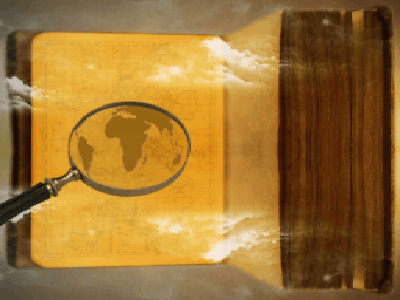

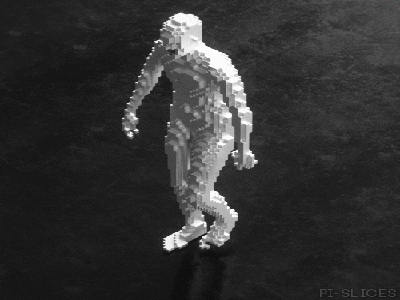

In [3]:
#Test call
trigger_event("space sound")

trigger_event("examine")

trigger_event("footstep")


In [ ]:
import os
import time
import threading
import platform
from PIL import Image
from IPython.display import display, clear_output
import requests
import io
import hashlib

try:
    from playsound import playsound
except ImportError:
    raise ImportError("Please install playsound with: pip install playsound==1.2.2")


# =============================================
# ⚙️ CONFIGURATION
# =============================================

TRIGGERS = {
    "space sound": {  # Space ambient sound for 20 minutes
        "sound": "https://drive.google.com/uc?export=download&id=1TH3ssE0tVnfKySil0q55grCoiFpCxFO7",
        "image": None,
        "loop_minutes": 20,  # ⏱️ loop for 20 minutes
    },

    "examine": {
        "sound": "https://drive.google.com/uc?export=download&id=1_FbFeK51rtIMWg9yQovpurNGHHWukYoD",
        "image": "https://drive.google.com/uc?export=download&id=1igPXeO1Ro-UUL1tMQsMAQqOZE1kPundT",
    },
    "found key": {
        "sound": "https://drive.google.com/uc?export=download&id=1MhGR7E9YXp7LrzKaSMlCGd211I18P6Iy",
        "image": "https://drive.google.com/uc?export=download&id=1hcyiCkmmchsGZ2ERsx8PMdEN3kh--tO5",
    },
    "not found key": {
        "sound": "https://drive.google.com/uc?export=download&id=17v52HWgz_jCHFITeCV1oyOOC4TV_gyzT",
        "image": None,
    },
    "door locked": {
        "sound": "https://drive.google.com/uc?export=download&id=1-BwRmk_3U6TRESsPja5s26ECB8GYcqOU",
        "image": "https://drive.google.com/uc?export=download&id=1drL22OHO91OgjpT942g2nrmgRZcr0gYa",
    },
    "door unlocked": {
        "sound": "https://drive.google.com/uc?export=download&id=16bhcdxVRzIRmNO0ztLaeQZYHBLPVlB8P",
        "image": "https://drive.google.com/uc?export=download&id=1TXSjKZXC_K0c4gXrQlTY20u_X2aEVQ1_",
    },
    "footstep": {
        "sound": "https://drive.google.com/uc?export=download&id=1mlkfF9RW6uhKMeBqixYZlo5w-dVJ_1Uo",
        "image": "https://drive.google.com/uc?export=download&id=16snfruJnkMN8fkxL_fxDzwCaNhNdRroN",
    },
    "outside": {
        "sound": "https://drive.google.com/uc?export=download&id=13vxJyjMuAz0hHfoaqLIrmOEbf5IN8BGW",
        "image": None
    },
}

CACHE_DIR = "cache"
os.makedirs(CACHE_DIR, exist_ok=True)


# =============================================
# 🧠 UTILITIES
# =============================================

def download_file(url: str, name: str) -> str | None:
    """Download a file if not cached, return local path."""
    url_hash = hashlib.md5(url.encode()).hexdigest()[:8]
    base, ext = os.path.splitext(name)
    unique_name = f"{base}_{url_hash}{ext}"
    local_path = os.path.join(CACHE_DIR, unique_name)

    if os.path.exists(local_path):
        return local_path

    print(f"⬇️ Downloading {name}...")
    try:
        response = requests.get(url, timeout=15)
        response.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(response.content)
        return local_path
    except Exception as e:
        print(f"⚠️ Download error: {e}")
        return None


# =============================================
# 🔊 SOUND PLAYER
# =============================================

def play_sound(url: str, trigger_name: str, loop_duration: int = None):
    """Play sound asynchronously, optionally looping for a given duration (seconds)."""
    local_file = download_file(url, f"{trigger_name}.mp3")
    if not local_file:
        return

    def _play():
        try:
            start_time = time.time()

            while True:
                # Play sound synchronously (wait until it ends)
                if platform.system() == "Darwin":
                    os.system(f"afplay '{local_file}' >/dev/null 2>&1")
                elif platform.system() == "Linux":
                    os.system(f"mpg123 -q '{local_file}'")
                else:
                    playsound(local_file, block=True)

                # Stop looping if time exceeded
                if loop_duration and (time.time() - start_time > loop_duration):
                    break

                # Sleep briefly before next loop to prevent overlap
                time.sleep(0.2)

        except Exception as e:
            print(f"⚠️ Sound error: {e}")

    threading.Thread(target=_play, daemon=True).start()

# =============================================
# 🖼️ IMAGE DISPLAY (INLINE)
# =============================================

def show_image_inline(url: str, display_time: int = 5000):
    """Display image inline in Jupyter (resized to consistent size)."""
    if not url:
        return

    try:
        local_file = download_file(url, "image.gif")
        if not local_file:
            return

        img = Image.open(local_file)

        # 🖼️ Resize to consistent size (same as "examine")
        target_size = (400, 300)  # width x height in pixels
        img = img.resize(target_size, Image.Resampling.LANCZOS)

        # Display inline in Jupyter
        display(img)

        # Clear the image after a few seconds
        def safe_clear_output():
            try:
                clear_output(wait=True)
            except LookupError:
                pass

        threading.Timer(display_time / 1000, safe_clear_output).start()

    except Exception as e:
        print(f"⚠️ Image error: {e}")


# =============================================
# 🚀 MAIN TRIGGER FUNCTION
# =============================================

def trigger_event(trigger_name: str, display_time: int = 5000):
    """Trigger sounds and images (supports looped ambient sounds)."""
    trigger_name = trigger_name.lower().strip()
    data = TRIGGERS.get(trigger_name)

    if not data:
        print(f"⚠️ Unknown trigger: {trigger_name}")
        return

    # Optional looping for long ambient sounds
    loop_minutes = data.get("loop_minutes", None)
    loop_duration = loop_minutes * 60 if loop_minutes else None

    # 🎧 Play sound
    if data.get("sound"):
        play_sound(data["sound"], trigger_name, loop_duration=loop_duration)

    # 🖼️ Show image
    if data.get("image"):
        show_image_inline(data["image"], display_time)


NameError: name 'Queue' is not defined

In [ ]:
trigger_event("space sound")

trigger_event("found key")

---
## GAME FUNCTIONS
PLAYER ACTION takes player_input to then call another function from a list of actions  using utils.py file with those functions 

#### ACTION 0 : SHOW AVAILABLE ACTIONS + PLAYER INPUT
```
SABINA COMMENT: You can do `return action` instead of `break`. `return` automatically stops the function so because the while loop is INSIDE the function, then it will stop as well once the action is returned.

```

---
### GAME INTRO:

In [ ]:
# initialize game by printing welcome message
print("Welcome to the Escape Room Game!")

# Big "Time's Up" banner
print("\n" + "*"*60)
print("*****         WELCOME TO THE ESCAPE ROOM GAME!         *****")
print("*****               Made by POSH SPICE                 *****")
print("*"*60 + "\n")

---
### Libraries & packages:

In [ ]:
import sys
sys.path.append("modules")  # add the folder to Python path
import utils # functions in python file utils.py

### ACTION 0 : SHOW AVAILABLE ACTIONS + PLAYER INPUT

In [ ]:
#ACTION 0) define function : player_action(player_input)
# While Loop, if else, break, return : player_action function
def player_action(player_input: str):
    while player_input != 'quit' and player_input != 'restart': # While player_input is not 'quit' and 'restart'
        print("\nChoose an actions :",actions) # Print the list of actions
        action = input("PLAYER! Choose your action :").lower() # Player inputs space of choice
        if action in actions:
            return action
        elif action == 'quit': # Exit the function to restart the game
            print("Quitting the game. Goodbye!")
            break
        elif action == 'restart': # Restart the game
            print("Game restarting!")
            player_action('play')
        else:
            print("Value Error, choose again!")
    return action

In [ ]:
# Call player_action function with player_input
action = player_action(player_input)
print(f"Player input the  action : {action}")

In [ ]:
current_space = 'game room'

def quiz(current_door):
    # Quiz function to unlock doors
    if (game_state.inventory in current_door):
        print("This door is already unlocked ~ you can proceed!")
        return player_action('play')
    else:
        print("Answer the following question to unlock the door:")
        print("What is 7 + 6?")
        answer = int(input("Your answer: "))
        if answer == 13:
            print("Correct! The door is now unlocked...")
            game_state.inventory.append(current_door)
            return True
        else:
            print("Incorrect answer. Try again!")
            return quiz(current_door)
    return player_action('play')

# call function: quiz()
quiz('door A')

In [ ]:
import utils
  # define Function : player_input()
  def player_input():
    player_input = input("PLAYER! Choose your action :")  # player inputs action from list actions
    # While Loops until we are outside condition
    while True:
      if player_input in actions:
        print("Player chose to : ",player_input)
        action = player_input
        break
      else:
        print("Typing Error, choose your action again!")
    return (getattr(utils, action)())

  # Call Function : player_action()
  player_input()

In [ ]:
import utils

# Define actions list
actions = ["run", "attack", "defend"]  # Example actions, replace with your own

# Define Function: player_input()
def player_input():
    while True:
        player_action = input("PLAYER! Choose your action: ")  # ask for input inside loop
        if player_action in actions:
            print("Player chose to:", player_action)
            return getattr(utils, player_action)()  # call the function from utils
        else:
            print("Typing Error, choose your action again!")

# Call Function: player_input()
player_input()


In [ ]:
# LIST : actions available to a player
actions = ['explore', 'examine', 'unlock door', 'navigate', 'restart', 'quit']
print("Player's actions in the game :",actions)

# LIST : items
items = ['couch', 'piano', 'queen bed', 'double bed', 'dresser', "dining table"]
print("\nItems in the game :",items)

# LIST : doors
doors = ['door A', 'door B', 'door C', 'door D']
print("\nDoors in the game :",doors)

# LIST : keys
keys = ['key door A', 'key door B', 'key door C', 'key door D']
print("\nKeys in the game :",keys)

In [ ]:
# use getattr to call explore function from utils  
player_input = '' #initialize player_input variable
print("Here is a list of actions :",actions) # Print the list of actions

player_input= input("PLAYER! Type your next move and press <Enter>: ").lower() 
player_action(player_input)
print(f"\nPlayer input your action : {getattr(utils, action)}")

function_return = getattr(utils, action)()  # Call the function with the same name as the action
print("Return:", function_return)

In [ ]:
import utils

# define Function : explore(current_space)

current_space = 'game room'
# Function: explore(current_space)
def explore(current_space):
    print(f"You are exploring {current_space}. You see these items:")
    for item in items:
        print("-", item)
    return items

action = 'explore'
# use getattr to call explore function from utils  
print(f"\nPlayer input your action : {action}")
function_return = getattr(utils, action)()  # Call the function with the same name as the action
print("Return:", function_return)

In [ ]:
import utils

# List of actions
actions = ['explore', 'examine', 'unlock_door', 'navigate', 'restart', 'quit']

# Example: dynamically call function based on the list
for action in actions:
    print(f"\nCalling action: {action}")
    function_return = getattr(utils, action)()  # Call the function with the same name as the action
    print("Return:", function_return)

### prabhsheen 
  

In [ ]:
def door_a_quiz():
    print("Question: What is the primary function of Door A, as suggested by its location in the floor plan?")
    print("A) To access the outdoors.")
    print("B) To provide entry or exit to a specific room.")
    print("C) To serve as a decorative element.")

    answer = input("Enter your choice (A, B, or C): ").upper()

    if answer == "B":
        print("Correct! Door A is most likely for entering or exiting a room.")
    else:
        print("Incorrect. Try again!")

door_a_quiz()

def door_b_quiz():
    print("Question: Considering the layout, which room is Door B most likely connected to?")
    print("A) The Game Room")
    print("B) Bedroom 1")
    print("C) The Outdoors")

    answer = input("Enter your choice (A, B, or C): ").upper()

    if answer == "B":
        print("Correct! Based on the plan, Door B likely leads to Bedroom 1.")
    else:
        print("Incorrect. Try again!")

door_b_quiz()

def door_c_quiz():
    print("Question: If you wake up on the couch, and the key to Door C is found nearby, what is the most logical room Door C leads to, considering the floor plan?")
    print("A) The Game Room")
    print("B) Bedroom 2")
    print("C) The Outdoors")

    answer = input("Enter your choice (A, B, or C): ").upper()

    if answer == "C":
        print("Correct! It makes sense that Door C might lead outside.")
    else:
        print("Incorrect. Consider the layout again!")

door_c_quiz()

def door_d_quiz():
    print("Question: Considering the floor plan, and the fact you woke up on the couch, where is Door D most likely located?")
    print("A) In the Game Room")
    print("B) In Bedroom 1")
    print("C) Not visible on the plan")

    answer = input("Enter your choice (A, B, or C): ").upper()

    if answer == "C":
        print("Correct! Since Door D isn't shown, it's not visible on the plan.")
    else:
        print("Incorrect. Maybe Door D is a secret door?")

door_d_quiz()


#### ACTION 1 : EXPLORE(current_space) returns items which is list of furnitures in current_space

In [ ]:
import utils

# initialize current space
current_space = 'game room'

# update current space from user input 
current_space = input("Which space you are in?")

# define Function : explore(current_space)
def explore(current_space):
    items = []
    if current_space == 'game room':
        items = ['couch', 'piano', 'queen bed', 'double bed', 'dresser', "dining table"]
    elif current_space == 'kitchen':
        items = ['fridge', 'oven', 'sink', 'table', 'chairs']
    elif current_space == 'bedroom':
        items = ['bed', 'wardrobe', 'nightstand', 'lamp']
    return items # return items in the current space

explore(
    utils.explore()
)

#### ACTION 3 : UNLOCK DOOR
```

  # Define Function : def unlock_door():
  def unlock_door():
    door = input("Type the door you want to try unlock : ")
  return door

  # Call Function : unlock_door()
  unlock_door()

---------------------------------------------------------------
#### Compare two strings using if 'door A' in inventory list of keys
#### since "door A" is part of the string "key door A" we get true
#### or we can approach it in a different way
```

In [ ]:
#

# Define Function : def unlock_door():
def unlock_door():
  door = input("Type the door you want to try unlock : ")
  return door

# Call Function : unlock_door()
unlock_door()


#### ACTION 4 : NAVIGATE
```

  # Define Function : def navigate():
  def navigate():
    answer = low(input("Test key? Answer yes or no"))   
    # yes = True | no = False
    if answer=yes
    current_space =
  return current_space

  # Call Function : navigate()
  navigate()

---------------------------------------------------------------
####
####
####
```

### PLAYER ACTIONS

We define actions of the player

**STEPS:**
1. We show the actions for the Player
2. We prompt the player to choose with error handling in mind
3. We print the chosen action


In [ ]:
# List: Actions available to the player
actions = ['explore', 'examine', 'unlock door', 'navigate', 'quit', 'restart'] # definition of list of actions

# Print the list
print("Here is a list of actions :",actions)
player_input = 'play'

# While Loop, if else, break : action_choice
while player_input != 'quit': # While Loop
  action_choice = input("PLAYER! Choose your action :").lower() # Player inputs space of choice

  if action_choice in actions:
    print("Player chose to :",action_choice)
    break
  else:
    print("Typing Error, choose again!")
    # SABINA COMMENT: This would technically be a ValueError, not TypingError. Typing error is when you input a float instead of a string
    # but Value error is when you put "get me out of the game" instead of "quit"


In [ ]:
# Function unlock door
door = 'door A'
door = 'door B'
def navigate(door):
  if door in 'key door A' # SABINA COMMENT: This value is hard-coded, so this function
                          # will only work for opening door A and it will cause you issues down the line...
    print('unlocked! you enter a new space.')
  else:
    print('door locked! you need a key.')
    return door




In [ ]:
# ACTION 0 : Define Function : PRINT AVAILABLE CHOICES
def player_choice():
  choice = input("Choose what action you want to do:")
  return choice
player_choice() # Call function

# ACTION 1 : EXPLORE SPACE
# Define Function :
def explore_space():
  space = input("Which item do you want to examine?")
  return

# ACTION 2 : EXAMINE ITEM
# Define Function :
def examine_item():
  item = input("Which item do you want to examine? ")
  return item

# SABINA CLARIFICATION: What's happening with the examine_item? Will you be adding more things in this function?


# Use the return to compare
if examine_item() in actions[examine]:
  print("Player examines the :", examine_item())

# ACTION 3 : UNLOCK DOOR
# Define Function :
def unlock_door():
  if 'door A' in 'key door A':
    door='door A'
  return door

# ACTION 4 : ENTER SPACE
# Define Function :
def enter_space():
  return current_space

#### ACTION 2 : EXAMINE ITEM
```

  # Define Function : def examine_item(space):
  def examine_item(space):
    
    item = input("Type the item you want to examine : ")
  return item

  # Call Function : examine_item()
  examine_item()

# Call Function : examine_item(current_item)
  examine_item()
  
---------------------------------------------------------------
#### Use the return to compare
#### if examine_item() in actions[examine]:
#### print("Player examines the :", examine_item())
```

In [ ]:
# ACTION 2 : EXAMINE ITEM
getattr(:)


## HOW TO DO

In [ ]:
# HOW TO : Access keys of the dictionary using .keys()
game_keys = game_areas.keys()
print(game_keys)

In [ ]:
# HOW TO : count (Number of elements) in a (List)
# Example
my_list = ["apple", "banana", "cherry"]

# Using len() to get the number of elements
number_of_elements = len(my_list)

# Now, number_of_elements holds the number of elements in the list
print("The number of elements in the list is:", number_of_elements)
# SABINA COMMENT: no_of_elements is a bit shorter and still understandable

In [ ]:
# HOW TO : access an (element) of a (list)
print("\nAccessing an element in a List of Actions:")
number_actions = len(actions)
for i in range(number_actions):
  print("-", actions[i])

# Automated Access

In [ ]:
# HOW TO : access a (value) in a (dictionary)
print("\nAccessing a value in a Dictionary value:")
print(game_areas["Living Room"])


# HOW TO : access an (element) of a list (value) in a (dictonary)
# Example How to access 'piano' in this dictionary
print("\nAccessing an element of a list value in a dictionary:")
print(game_areas["Living Room"][2])

In [ ]:
# HOW TO : define a Function :
def examine_item():
  a=int(input("Enter number a: "))
  b=int(input("Enter number b: "))
  return a+b

In [ ]:
# HOW TO : How to define a Function - METHOD 1
# Define Function : sums numbers does not take immediate input:
def sum_numbers():
  a=int(input("Enter number a: "))
  b=int(input("Enter number b: "))
  return a+b

# Call Function : sum_numbers()
sum_numbers()

In [ ]:
# HOW TO : How to define a Function - METHOD 2
# Define Function : sums numbers does not take immediate input :
def sum_numbers(a,b):
  return a+b

# Manual input for a Function variables
a=int(input("Enter number a: "))
b=int(input("Enter number b: "))

# Call Function : sum_numbers(a,b)
sum_numbers(a,b) # using a,b variables from the input outside of function definition

## CODE

In [ ]:
# CODE : Automate access of an (element) of a (value) in a (dictonary)
search = input("Enter what element you're searching : ")
for i in spaces:
  for y in len(spaces):
    print(game_areas.space[i][y])
# SABINA QUESTION : We are curious to how to automate access to an element of a value that is a list in a dictionary
# for i in range(len(list)): -> this iterates over the same number as the elements in a list

In [ ]:
# CODE :
# Update current space
current_space = game_areas.keys()

# Note: You might want to iterate through the keys or access a specific key depending on your game logic.
# For example, to access the first key:
# first_room = list(current_space)[0]
# print(f"The first room is: {first_room}")

In [ ]:
# CODE :
# Current space is a value
# It will get updated
# 1st Space
current_space = "Game Room"
print("1st space is :", current_space)

# 2nd Space
current_space = "Bedroom 1"
print("2nd space is :", current_space)

# 3rd Space
current_space = "Bedroom 2"
print("3rd space is :", current_space)


In [ ]:
# CODE :
# List : current_space
current_space = ["Game Room"]
# 1st Space
print("1st space is :", current_space[0])

space_path = ["Game Room", "Bedroom 1", "Bedroom 2", "Bedroom 1", "Living Room", "Outside"]

In [ ]:
# CODE :
# Mapping the best shortest player's space path
space_path = ["Game Room", "Bedroom 1", "Bedroom 2", "Bedroom 1", "Living Room", "Outside"]

# Print shortest space path map
print(space_path)

In [ ]:
# CODE :
# List : paths
space_paths = ["Game Room"]

# Print List space_paths
print(space_paths)

In [ ]:
# CODE :
# Updating List space_paths by adding current_space
space_paths.add(current_space)

In [ ]:
# CODE :
#Print values of each list seperately
for i in spaces:
  print(game_areas[i])

In [ ]:
# CODE :
# List: Furniture list for all the items to be examined in order to find the keys
examine = ['couch', 'piano', 'queen bed', 'double bed', 'dresser', 'dining table']
print("Furnitures to examine:",examine)

# Compare examine with current space to update the inventory

In [ ]:
# CODE :
# Compare the elements in the current space with examine furniture

if game_areas["Living Room"][0] in examine:
    print("found")
else:
    print("not found")

In [ ]:
# CODE :
# Update Current Space METHOD compare with furniture in the space
for i in spaces:
  if game_areas["Bedroom 1"][0] in examine:
    print("found")
  else:
    print("not found")
# Use BREAK to leave loop when found

# Update current space METHOD compare with doors in the space

In [ ]:
# CODE :
# Manual Access an action (element) of a list
print("\nAccessing an element in List of ACTIONS :",actions[1])

In [ ]:
# CODE :
# List: Inventory of the aquired keys to unlock the doors
Inventory = []
print("Inventory :", Inventory)

# Update Inventory example (still in game room and found key door A)
Inventory = ["key door A"]
print("Inventory :", Inventory)

In [ ]:
# CODE :
# List: Furniture list found in current space
furniture_found = []
print("Furniture found :", furniture_found)

# Example List: Furniture list found in start space
furniture_found = ['couch']
print("Furniture found :", furniture_found)

SABINA COMMENT: I see you don't have the code from the loop here. I would say to add that in so you can test the changes you do to the functions every time you make a change. At the moment it looks like you're focusing on all the different elements but don't have the full picture.

**So please try to make a working loop (either the one in the sample_code or one that you create with your own actions) as your next step before you work on any more details! The MVP (Minimum Viable Product) needs to come first!**

# GAME CODE

In [ ]:
# Start the game by printing storyline message and initial game state
 
print('''
    You wake up on a couch and find yourself in a strange house with no windows which you have never been to before.
    You don't remember why you are here and what had happened before. 
    You feel some unknown danger is approaching and you must get out of the house, NOW!
          ''')
current_space = 'game room'
# call function player_action(player_input='play')
player_action('play') 
# call explore(current_space) current_space stored in game_state dictionary
getattr(utils, "explore")(game_state["current_space"]) 


In [ ]:
# define function INIT_GAME_STATE()
def INIT_GAME_STATE():
    """
    Initialize the game state
    """
    return {
        "current_space": "Game Room",
        "inventory": [],
    }

In [ ]:
# Initialize game state in Game Room
game_state = INIT_GAME_STATE()
# call function start_game()
start_game()

In [ ]:
# define function start_game()
def start_game():
    """
    Start the game
    """
    print("You wake up on a couch and find yourself in a strange house with no windows which you have never been to before. You don't remember why you are here and what had happened before. You feel some unknown danger is approaching and you must get out of the house, NOW!")
    play_room(game_state["current_space"])

In [ ]:
# define function linebreak()
def linebreak():
    """
    Print a line break
    """
    print("\n\n")

## REYNOLD WORK

In [ ]:
# Keep track of the player : current space; current item to examine; and inventory of keys

# Dictionary : GAME STATE
game_state = {
    'time': ["display_clock_countdown"] , #library time for live timer and countdown
    'space path' : [], # player current space to navigate and make a space path
    'item path' : [], # to select an item to examine for key; and make an item path
    'inventory': [], # to store found keys

}


In [ ]:
# Add a new key 'score' with an initial value, for example 0
game_state['score'] = 0

# Add another key 'player_health' with a value of 100, for example
game_state['player_health'] = 100

# Check the updated dictionary
print(game_state)

In [ ]:
import time

# Initialize game state with player health
game_state = {
    'time': ["display_clock_countdown"],
    'space path': [],
    'item path': [],
    'inventory': [],
    'player_health': 100.0,  # Using float for percentage calculations
    'start_time': None,
    'next_deduction_time': 300  # Deduction starts after 5 minutes
}

def start_game():
    """Start the game's timer."""
    game_state['start_time'] = time.time()
    print("Game started! Timer is running.")

def update_player_health():
    """Update player health based on elapsed time."""
    if game_state['start_time'] is not None:
        elapsed_time = time.time() - game_state['start_time']

        # Perform deduction only if elapsed time is beyond next scheduled deduction time
        if elapsed_time >= game_state['next_deduction_time']:
            # Reduce health by 15%
            game_state['player_health'] *= 0.85
            print(f"Health decreased by 15%! New health: {game_state['player_health']:.2f}")

            # Update the next deduction time for 2 minutes later
            game_state['next_deduction_time'] += 120

def game_loop():
    """Main game loop."""
    start_game()
    while game_state['player_health'] > 0:
        current_time = time.time()
        # Calculate the time left until the next deduction
        time_until_next_deduction = game_state['next_deduction_time'] - (current_time - game_state['start_time'])

        # Determine sleep time, making sure not to go negative
        sleep_time = max(0, time_until_next_deduction)

        # Sleep until the next deduction is expected
        if sleep_time > 0:
            time.sleep(sleep_time)

        # Update player health based on time
        update_player_health()

        # Provide feedback on current status
        print(f"Current player health: {game_state['player_health']:.2f}")
        if game_state['player_health'] <= 0:
            print("Game Over!")

# Start the game loop
if __name__ == "__main__":
    game_loop()

## PAULINA: The Take a break

DEFINIG THE FUNCTION take_a_break()

**Step 1: The idea**

- When the player starts the game, we note the start time.
- Every second, we check how long the player has been playing.
- If it’s less than 40 minutes, keep playing.
- If it’s 40 minutes or more, stop the game and show this message:

TAKE A BREAK FOR MENTAL HEALTH: Breathe in, breathe out. Take some food, drink a cup of water & rest. Come back later.

- Then we wait 30 minutes before letting them play again

**Step 2: define what variables we need**

In [ ]:
from datetime import datetime, timedelta # timedelta means difference between two times

start_time = datetime.now()       # when the session started
break_until = None                # time when the break ends


**Step 3: The function**

In [ ]:
from datetime import datetime, timedelta # timedelta means difference between two times
import time

def take_a_break():
    global start_time, break_until

    now = datetime.now()

    # 1. If we are already in a break
    if break_until is not None:
        if now < break_until:
            remaining = break_until - now
            mins = int(remaining.total_seconds() // 60)
            secs = int(remaining.total_seconds() % 60)
            print(f"\n Still on break! Please wait {mins:02}:{secs:02} minutes.")
            return False
        else:
            # Break finished, reset timer
            print("\n Break finished! You can play again.\n")
            start_time = datetime.now()
            break_until = None
            return True

    # 2. If no break is active, check play time
    minutes_played = now - start_time
    if minutes_played >= timedelta(minutes=40):
        # Start break
        break_until = now + timedelta(minutes=30)
        print("""
========================================================
TAKE A BREAK FOR MENTAL HEALTH:
Breathe in, breathe out. Take some food, drink a cup of water & rest.
Come back later.
========================================================
""")
        return False
    else:
        return True




In [ ]:
from datetime import datetime, timedelta # timedelta means difference between two times
import time

# === GLOBAL VARIABLES ===
start_time = datetime.now()
break_until = None

def take_a_break():
    """Check if it's time for a break or if the player can keep playing."""
    global start_time, break_until

    now = datetime.now()

    # 1) If we are already in a break
    if break_until is not None:
        if now < break_until:
            remaining = break_until - now
            mins = int(remaining.total_seconds() // 60)
            secs = int(remaining.total_seconds() % 60)
            print(f"\nStill on break! Please wait {mins:02}:{secs:02} minutes.")
            return False
        else:
            # Break finished
            print("\nBreak finished! You can play again.\n")
            start_time = datetime.now()
            break_until = None
            return True

    # 2) If no break is active, check play time
    time_played = now - start_time

    # Change 'minutes' to 'seconds' for quick testing
    if time_played >= timedelta(minutes=40):
        break_until = now + timedelta(minutes=20)
        print("""
========================================================
TAKE A BREAK FOR MENTAL HEALTH:
Breathe in, breathe out. Take some food, drink a cup of water & rest.
Come back later.
========================================================
""")
        return False
    else:
        return True


# Hier ist a demo loop to show how take_a_break() works
if __name__ == "__main__":
    print("Demo started. Press Ctrl + C to stop.\n")

    try:
        while True:
            allowed = take_a_break()
            if allowed:
                print("Playing...")
            time.sleep(1)  # one tick per second
    except KeyboardInterrupt:
        print("\nStopped by user. Exiting cleanly.\n")
